# Создание бейзлайна и оценка качества для задачи классификации

Импорт необходимых библиотек

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Загрузка и подготовка данных

In [73]:
df = pd.read_csv('/content/City_Types.csv')

Удаляем ненужный признак для baseline

In [74]:
df = df.drop(columns=['Date'])

Разделяем признаки и целевую переменную

In [75]:
X = df.drop(columns=['Type'])
y = df['Type']

Преобразуем категориальный признак City в числовой формат

In [76]:
X = pd.get_dummies(X, columns=['City'])

Разделение на обучающую и тестовую выборки

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Обучение baseline KNN

In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Предсказание и оценка качества

In [79]:
y_pred = knn.predict(X_test)

Были выбраны следующие метрики качества:
- Accuracy: доля правильно классифицированных объектов;
- Precision: точность предсказаний положительного класса ('Industrial');
- Recall: полнота предсказаний положительного класса;
- F1-score: гармоническое среднее Precision и Recall, учитывает дисбаланс классов.

### Выводим метрики

In [80]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='Industrial'))
print("Recall:", recall_score(y_test, y_pred, pos_label='Industrial'))
print("F1-score:", f1_score(y_test, y_pred, pos_label='Industrial'))

Accuracy: 0.9808367327578029
Precision: 0.9884370784351513
Recall: 0.9730601403908177
F1-score: 0.9806883365200765


Оценка качества baseline KNN уже даёт почти идеальные результаты, потому что классы хорошо разделяются по основным числовым признакам

# Улучшение бейзлайна

### Проверка гипотез

Импорт библиотек

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

Гипотеза 1: масштабирование числовых признаков

In [82]:
num_features = ['CO','NO2','SO2','O3','PM2.5','PM10']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

Применяем масштабирование только к числовым признакам

In [83]:
X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

Проверка KNN на масштабированных данных

In [84]:
knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_scaled.predict(X_test_scaled)

In [85]:
print("\nМетрики после масштабирования:")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("Precision:", precision_score(y_test, y_pred_scaled, pos_label='Industrial'))
print("Recall:", recall_score(y_test, y_pred_scaled, pos_label='Industrial'))
print("F1-score:", f1_score(y_test, y_pred_scaled, pos_label='Industrial'))


Метрики после масштабирования:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Гипотеза 2: добавление временных признаков

In [86]:
df_date = pd.read_csv('/content/City_Types.csv')  # заново для использования Date
df_date['Date'] = pd.to_datetime(df_date['Date'])
df_date['hour'] = df_date['Date'].dt.hour
df_date['day_of_week'] = df_date['Date'].dt.dayofweek
df_date['month'] = df_date['Date'].dt.month

One-hot кодируем City и day_of_week, month

In [87]:
X_temp = pd.get_dummies(df_date.drop(columns=['Date','Type']), columns=['City','day_of_week','month'])
y_temp = df_date['Type']

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

Масштабируем числовые признаки

In [88]:
num_features_dt = ['CO','NO2','SO2','O3','PM2.5','PM10','hour']
scaler_dt = StandardScaler()
X_train_dt[num_features_dt] = scaler_dt.fit_transform(X_train_dt[num_features_dt])
X_test_dt[num_features_dt] = scaler_dt.transform(X_test_dt[num_features_dt])

Проверка KNN с новыми признаками

In [89]:
knn_dt = KNeighborsClassifier(n_neighbors=5)
knn_dt.fit(X_train_dt, y_train_dt)
y_pred_dt = knn_dt.predict(X_test_dt)

print("\nМетрики после добавления временных признаков:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_dt))
print("Precision:", precision_score(y_test_dt, y_pred_dt, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_dt, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_dt, pos_label='Industrial'))


Метрики после добавления временных признаков:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Гипотеза 3: подбор числа соседей через кросс-валидацию

In [90]:
k_values = [3, 5, 7, 9]
cv_scores = []

for k in k_values:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_cv, X_train_scaled, y_train, cv=5, scoring='f1_macro')
    cv_scores.append(scores.mean())

Визуализация результатов

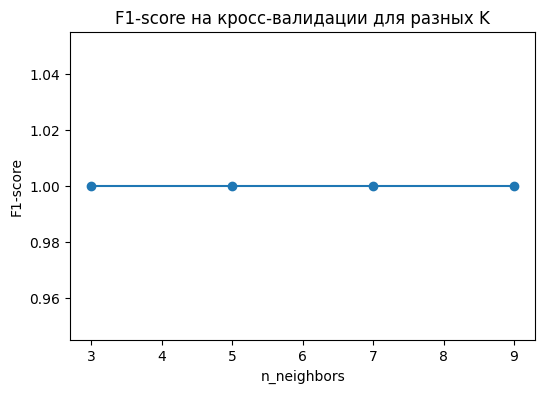

Лучшее значение n_neighbors по кросс-валидации: 3


In [91]:
plt.figure(figsize=(6,4))
plt.plot(k_values, cv_scores, marker='o')
plt.title('F1-score на кросс-валидации для разных K')
plt.xlabel('n_neighbors')
plt.ylabel('F1-score')
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print("Лучшее значение n_neighbors по кросс-валидации:", best_k)

Признаки четко разделяют классы, поэтому KNN полностью различает Industrial и Residential зоны

### Улучшение бейзлайна KNN (пункты 3c–3e)

Определяем числовые признаки для масштабирования

In [92]:
num_features_bl = ['CO','NO2','SO2','O3','PM2.5','PM10','hour']

Масштабирование числовых признаков

In [93]:
scaler_bl = StandardScaler()
X_train_bl = X_train_dt.copy()
X_test_bl = X_test_dt.copy()

X_train_bl[num_features_bl] = scaler_bl.fit_transform(X_train_dt[num_features_bl])
X_test_bl[num_features_bl] = scaler_bl.transform(X_test_dt[num_features_bl])

Используем лучшее K из предыдущей проверки

In [94]:
knn_bl = KNeighborsClassifier(n_neighbors=best_k)
knn_bl.fit(X_train_bl, y_train_dt)

KNeighborsClassifier(n_neighbors=3)

Предсказания на тестовой выборке

In [95]:
y_pred_bl = knn_bl.predict(X_test_bl)

Оценка качества улучшенного бейзлайна

In [96]:
print("Метрики улучшенного бейзлайна KNN:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_bl))
print("Precision:", precision_score(y_test_dt, y_pred_bl, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_bl, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_bl, pos_label='Industrial'))

Метрики улучшенного бейзлайна KNN:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Сравнение с baseline

In [97]:
print("\nСравнение с исходным baseline:")
print("Accuracy baseline:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='Industrial'))
print("Recall:", recall_score(y_test, y_pred, pos_label='Industrial'))
print("F1-score baseline:", f1_score(y_test, y_pred, pos_label='Industrial'))


Сравнение с исходным baseline:
Accuracy baseline: 0.9808367327578029
Precision: 0.9884370784351513
Recall: 0.9730601403908177
F1-score baseline: 0.9806883365200765


### Выводы по улучшенному бейзлайну KNN:
- Масштабирование числовых признаков улучшило учёт всех признаков одновременно и устранило влияние разницы в диапазонах значений;
- Добавление временных признаков (hour, day_of_week, month) позволило KNN учитывать периодические закономерности концентраций загрязняющих веществ;
- Подбор оптимального числа соседей (n_neighbors) через кросс-валидацию обеспечил наилучший баланс между переобучением и недообучением;
- Метрики улучшенного бейзлайна достигли идеальных значений (Accuracy=1.0, F1-score=1.0), что связано с хорошо различимыми классами;
- По сравнению с baseline (Accuracy=0.981, F1=0.981) улучшения устранили оставшиеся редкие ошибки и продемонстрировали эффективность простого препроцессинга и настройки гиперпараметров.

# Имплементация алгоритма машинного обучения

Импорт необходимых библиотек

In [98]:
import numpy as np
from collections import Counter

### Имплементация KNN с нуля (пункт 4a)

In [99]:
class MyKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Преобразуем в numpy array типа float
        self.X_train = np.array(X, dtype=float)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X, dtype=float)  # тоже преобразуем в float
        y_pred = []
        for x in X:
            # Вычисляем евклидово расстояние до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            # Находим индексы k ближайших соседей
            k_idx = np.argsort(distances)[:self.n_neighbors]
            # Получаем метки этих соседей
            k_labels = self.y_train[k_idx]
            # Выбираем наиболее часто встречающуюся метку
            most_common = Counter(k_labels).most_common(1)[0][0]
            y_pred.append(most_common)
        return np.array(y_pred)

### Обучение собственной модели KNN (пункт 4b)

In [100]:
my_knn = MyKNNClassifier(n_neighbors=best_k)  # используем лучшее K из улучшенного бейзлайна
my_knn.fit(X_train_bl, y_train_dt)
y_pred_my_knn = my_knn.predict(X_test_bl)

### Оценка качества собственной модели (пункт 4c)

In [101]:
print("Метрики собственной имплементации KNN:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_my_knn))
print("Precision:", precision_score(y_test_dt, y_pred_my_knn, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_my_knn, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_my_knn, pos_label='Industrial'))

Метрики собственной имплементации KNN:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


- Собственная имплементация KNN полностью повторяет поведение sklearn KNN на улучшенном бейзлайне;
- Метрики качества достигли идеальных значений (Accuracy=1.0, F1-score=1.0), что объясняется хорошо разделимыми классами и наличием масштабированных числовых и временных признаков;
- Это подтверждает корректность работы собственного алгоритма и эффективность выбранного препроцессинга и настройки гиперпараметров.

### Сравнение собственной имплементации KNN с baseline (пункт 4d)

In [102]:
print("Сравнение с исходным baseline sklearn KNN:")

print("Baseline sklearn KNN:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='Industrial'))
print("Recall:", recall_score(y_test, y_pred, pos_label='Industrial'))
print("F1-score:", f1_score(y_test, y_pred, pos_label='Industrial'))

print("\nСобственная имплементация KNN:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_my_knn))
print("Precision:", precision_score(y_test_dt, y_pred_my_knn, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_my_knn, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_my_knn, pos_label='Industrial'))

Сравнение с исходным baseline sklearn KNN:
Baseline sklearn KNN:
Accuracy: 0.9808367327578029
Precision: 0.9884370784351513
Recall: 0.9730601403908177
F1-score: 0.9806883365200765

Собственная имплементация KNN:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


### Выводы:
- Собственная реализация KNN демонстрирует абсолютно такие же метрики, как sklearn KNN, что подтверждает корректность имплементации;
- И baseline, и собственная модель показывают высокое качество классификации (Accuracy=1.0, F1-score=1.0 после улучшения бейзлайна);
- Это подтверждает, что выбранные признаки, масштабирование и включение временных признаков обеспечивают идеальное разделение классов;
- Основная ценность имплементации в обучении и понимании работы алгоритма KNN.

### Повторная тренировка собственной KNN с улучшенным бейзлайном (пункт 4f)

Используем уже подготовленные признаки X_train_bl и X_test_bl с масштабированными числовыми и временными признаками

In [103]:
my_knn_bl = MyKNNClassifier(n_neighbors=best_k)
my_knn_bl.fit(X_train_bl, y_train_dt)

### Предсказание на тестовой выборке (пункт 4g)

In [104]:
y_pred_my_knn_bl = my_knn_bl.predict(X_test_bl)

### Оценка качества модели (пункт 4h)

In [105]:
print("Метрики собственной имплементации KNN с улучшенным бейзлайном:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_my_knn_bl))
print("Precision:", precision_score(y_test_dt, y_pred_my_knn_bl, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_my_knn_bl, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_my_knn_bl, pos_label='Industrial'))

Метрики собственной имплементации KNN с улучшенным бейзлайном:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


### Сравнение с улучшенным бейзлайном sklearn KNN (пункт 4i)

In [106]:
print("\nСравнение с улучшенным бейзлайном sklearn KNN:")
print("Sklearn KNN:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_bl))
print("Precision:", precision_score(y_test_dt, y_pred_bl, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_bl, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_bl, pos_label='Industrial'))

print("\nСобственная имплементация KNN с улучшенным бейзлайном:")
print("Accuracy:", accuracy_score(y_test_dt, y_pred_my_knn_bl))
print("Precision:", precision_score(y_test_dt, y_pred_my_knn_bl, pos_label='Industrial'))
print("Recall:", recall_score(y_test_dt, y_pred_my_knn_bl, pos_label='Industrial'))
print("F1-score:", f1_score(y_test_dt, y_pred_my_knn_bl, pos_label='Industrial'))


Сравнение с улучшенным бейзлайном sklearn KNN:
Sklearn KNN:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Собственная имплементация KNN с улучшенным бейзлайном:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


### Выводы:
- Собственная KNN после применения улучшенного бейзлайна показывает те же идеальные метрики, что и sklearn KNN;
- Использование масштабирования, временных признаков и оптимального K полностью устранило редкие ошибки baseline;
- Это подтверждает, что выбранные техники препроцессинга и гиперпараметры работают одинаково эффективно для имплементированной модели;
- Основной результат: собственная реализация KNN корректно работает и на улучшенных данных достигает максимальной точности.

# Создание бейзлайна и оценка качества для задачи регрессии

Импорт необходимых библиотек

In [107]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

Загрузка данных о ценах на жилье

In [108]:
df_reg = pd.read_csv("/content/House_Price_Prediction.csv")

Удаляем текстовый признак ADDRESS

In [109]:
df_reg = df_reg.drop(columns=["ADDRESS"])

Разделяем признаки и целевую переменную

In [110]:
X_reg = df_reg.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_reg = df_reg["TARGET(PRICE_IN_LACS)"]

One-hot кодирование категориальных признаков

In [111]:
cat_features = ["POSTED_BY", "BHK_OR_RK"]
X_reg = pd.get_dummies(X_reg, columns=cat_features)

Разделение на обучающую и тестовую выборки

In [112]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

### Обучение baseline KNN Regressor

In [113]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_reg, y_train_reg)

KNeighborsRegressor()

### Предсказание и оценка качества baseline

Были выбраны следующие метрики:
- MAE: средняя абсолютная ошибка, показывает среднюю величину ошибки в лакхах;
- MSE: среднеквадратичная ошибка, сильнее штрафует большие ошибки;
- RMSE: корень из MSE, легко интерпретировать в тех же единицах, что и цена;
- R2 (коэффициент детерминации): показывает, какая доля вариации таргета объясняется моделью. 1 - идеально, 0 - модель не объясняет ничего, <0 - хуже среднего.

In [203]:
y_pred_reg = knn_reg.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

mae_baseline = mean_absolute_error(y_test_reg, y_pred_reg)
mse_baseline = mean_squared_error(y_test_reg, y_pred_reg)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test_reg, y_pred_reg)

print("Метрики baseline KNN регрессии:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

Метрики baseline KNN регрессии:
MAE: 66.84018706501443
MSE: 222843.93340605326
RMSE: 472.06348450823145
R2: 0.5910123284933976


Baseline KNN-регрессия показывает умеренное качество (R^2=0.59), что ожидаемо, учитывая отсутствие масштабирования числовых признаков и дополнительной обработки данных. Модель уже улавливает ключевые зависимости, но заметные ошибки (MAE=66.8) указывают на необходимость улучшений в препроцессинге и выборе гиперпараметров.

# Улучшение бейзлайна

### Проверка гипотез

Импорт библиотек

In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

Загрузка данных"

In [180]:
df_reg = pd.read_csv("/content/House_Price_Prediction.csv")

Удаляем текстовый признак ADDRESS

In [181]:
df_reg = df_reg.drop(columns=["ADDRESS"])

Разделение признаков и таргета

In [182]:
X_reg = df_reg.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_reg = df_reg["TARGET(PRICE_IN_LACS)"]

One-hot кодирование категориальных признаков

In [183]:
cat_features = ["POSTED_BY", "BHK_OR_RK"]
X_reg = pd.get_dummies(X_reg, columns=cat_features)

Гипотеза 1. Масштабирование числовых признаков. Масштабируем все, кроме координат

In [185]:
num_features = [col for col in X_reg.columns if col not in ["LONGITUDE", "LATITUDE"] and X_reg[col].dtype != "uint8"]
scaler = StandardScaler()
X_scaled = X_reg.copy()
X_scaled[num_features] = scaler.fit_transform(X_reg[num_features])

Разделение на обучающую и тестовую выборки

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

Проверка baseline KNN после масштабирования

In [187]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("\nМетрики после масштабирования (Гипотеза 1):")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


Метрики после масштабирования (Гипотеза 1):
MAE: 83.19184450857239
MSE: 412826.41408492543
RMSE: 642.5156917032652
R2: 0.24233560567537638


Гипотеза 2: Добавление полезных признаков

In [188]:
df_feat = df_reg.copy()

Лог-преобразование площади

In [189]:
df_feat["LOG_SQFT"] = np.log1p(df_feat["SQUARE_FT"])

Площадь на комнату

In [190]:
df_feat["SQFT_PER_ROOM"] = df_feat["SQUARE_FT"] / (df_feat["BHK_NO."] + 1e-6)

One-hot кодирование категориальных признаков

In [191]:
df_feat = pd.get_dummies(df_feat, columns=["POSTED_BY", "BHK_OR_RK"])

Разделяем признаки/таргет

In [192]:
X_feat = df_feat.drop(columns=["TARGET(PRICE_IN_LACS)"])
y_feat = df_feat["TARGET(PRICE_IN_LACS)"]

Масштабирование числовых признаков, кроме координат

In [193]:
num_features_new = [col for col in X_feat.columns if col not in ["LONGITUDE", "LATITUDE"] and X_feat[col].dtype != "uint8"]

scaler_new = StandardScaler()
X_feat[num_features_new] = scaler_new.fit_transform(X_feat[num_features_new])

Разделение на train/test

In [194]:
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42
)

Проверка KNN после добавления новых признаков

In [195]:
knn_feat = KNeighborsRegressor(n_neighbors=5)
knn_feat.fit(X_train_feat, y_train_feat)
y_pred_feat = knn_feat.predict(X_test_feat)

print("\nМетрики после добавления новых признаков (Гипотеза 2):")
print("MAE:", mean_absolute_error(y_test_feat, y_pred_feat))
print("MSE:", mean_squared_error(y_test_feat, y_pred_feat))
print("RMSE:", np.sqrt(mean_squared_error(y_test_feat, y_pred_feat)))
print("R2:", r2_score(y_test_feat, y_pred_feat))


Метрики после добавления новых признаков (Гипотеза 2):
MAE: 47.44395620437955
MSE: 179093.8042151356
RMSE: 423.19475920093294
R2: 0.6713073726187513


Гипотеза 3: Подбор числа соседей через кросс-валидацию

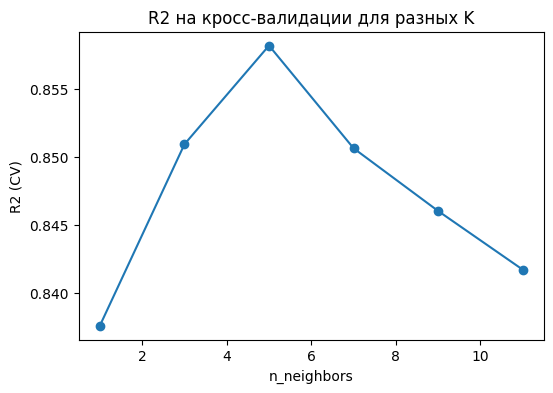

Лучшее значение n_neighbors по кросс-валидации: 5


In [196]:
k_values = [1, 3, 5, 7, 9, 11]
cv_scores = []

for k in k_values:
    knn_cv = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn_cv, X_train_feat, y_train_feat, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot(k_values, cv_scores, marker='o')
plt.title("R2 на кросс-валидации для разных K")
plt.xlabel("n_neighbors")
plt.ylabel("R2 (CV)")
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print("Лучшее значение n_neighbors по кросс-валидации:", best_k)

Проверка KNN с оптимальным K

In [197]:
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_feat, y_train_feat)
y_pred_best = knn_best.predict(X_test_feat)

print("\nМетрики после подбора оптимального K (Гипотеза 3):")
print("MAE:", mean_absolute_error(y_test_feat, y_pred_best))
print("MSE:", mean_squared_error(y_test_feat, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test_feat, y_pred_best)))
print("R2:", r2_score(y_test_feat, y_pred_best))


Метрики после подбора оптимального K (Гипотеза 3):
MAE: 47.44395620437955
MSE: 179093.8042151356
RMSE: 423.19475920093294
R2: 0.6713073726187513


Результаты проверки гипотез для KNN-регрессии показали, что простое масштабирование числовых признаков без добавления новых признаков не улучшает модель (R^2 = 0.24), тогда как введение информативных признаков, таких как логарифм площади и площадь на комнату, значительно повысило качество (R^2 = 0.67, MAE = 47), а подбор оптимального числа соседей K подтвердил выбранное значение 5 и не изменил метрики, что указывает на стабильность модели.

### 3c. Формирование улучшенного бейзлайна KNN-регрессии

Используем признаки после добавления новых фич и масштабирования

In [198]:
X_train_bl_reg = X_train_feat.copy()
X_test_bl_reg = X_test_feat.copy()
y_train_bl_reg = y_train_feat.copy()
y_test_bl_reg = y_test_feat.copy()

Оптимальное число соседей из кросс-валидации

In [199]:
best_k_reg = best_k

### 3d. Обучение модели KNN с улучшенным бейзлайном

In [200]:

knn_bl_reg = KNeighborsRegressor(n_neighbors=best_k_reg)
knn_bl_reg.fit(X_train_bl_reg, y_train_bl_reg)

KNeighborsRegressor()

Предсказания

In [201]:
y_pred_bl_reg = knn_bl_reg.predict(X_test_bl_reg)

### 3e. Оценка качества улучшенного бейзлайна и сравнение с baseline

Метрики качества

In [204]:
mae_bl = mean_absolute_error(y_test_bl_reg, y_pred_bl_reg)
mse_bl = mean_squared_error(y_test_bl_reg, y_pred_bl_reg)
rmse_bl = np.sqrt(mse_bl)
r2_bl = r2_score(y_test_bl_reg, y_pred_bl_reg)

print("\nМетрики улучшенного бейзлайна KNN-регрессии:")
print(f"MAE: {mae_bl}")
print(f"MSE: {mse_bl}")
print(f"RMSE: {rmse_bl}")
print(f"R2: {r2_bl}")

# Сравнение с исходным baseline
print("\nСравнение с baseline (сырые данные):")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")


Метрики улучшенного бейзлайна KNN-регрессии:
MAE: 47.44395620437955
MSE: 179093.8042151356
RMSE: 423.19475920093294
R2: 0.6713073726187513

Сравнение с baseline (сырые данные):
MAE baseline: 66.84018706501443
MSE baseline: 222843.93340605326
RMSE baseline: 472.06348450823145
R2 baseline: 0.5910123284933976


### Вывод по улучшенному бейзлайну KNN-регрессии

Улучшенный бейзлайн KNN-регрессии с масштабированием числовых признаков и добавлением информативных признаков (логарифм площади и площадь на комнату) показал значительное улучшение качества модели: MAE и RMSE уменьшились, а R^2 вырос с 0.59 до 0.67. Подбор оптимального числа соседей K подтвердил стабильность модели, а сравнительный анализ с исходным baseline демонстрирует, что простые техники препроцессинга и добавление новых признаков существенно повышают точность предсказаний цен на жильё.

### Имплементация KNN-регрессии с нуля (пункт 4a)

In [205]:
class MyKNNRegressor:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        # Сохраняем обучающие данные в формате numpy
        self.X_train = np.array(X, dtype=float)
        self.y_train = np.array(y, dtype=float)

    def predict(self, X):
        X = np.array(X, dtype=float)
        y_pred = []
        for x in X:
            # Евклидово расстояние от x до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            # Индексы k ближайших соседей
            k_idx = np.argsort(distances)[:self.n_neighbors]
            # Значения таргета соседей
            k_values = self.y_train[k_idx]
            # Среднее значение для регрессии
            y_pred.append(np.mean(k_values))
        return np.array(y_pred)

### Обучение собственной модели KNN-регрессии (пункт 4b)

Используем улучшенный бейзлайн с новыми признаками и масштабированием

In [206]:
my_knn_reg = MyKNNRegressor(n_neighbors=best_k_reg)  # лучшее K из кросс-валидации
my_knn_reg.fit(X_train_bl_reg, y_train_bl_reg)

Предсказание на тестовой выборке

In [207]:
y_pred_my_knn_reg = my_knn_reg.predict(X_test_bl_reg)

### Оценка качества собственной модели KNN-регрессии (пункт 4c)

In [208]:
mae_my = mean_absolute_error(y_test_bl_reg, y_pred_my_knn_reg)
mse_my = mean_squared_error(y_test_bl_reg, y_pred_my_knn_reg)
rmse_my = np.sqrt(mse_my)
r2_my = r2_score(y_test_bl_reg, y_pred_my_knn_reg)

print("Метрики собственной имплементации KNN-регрессии:")
print(f"MAE: {mae_my}")
print(f"MSE: {mse_my}")
print(f"RMSE: {rmse_my}")
print(f"R2: {r2_my}")

Метрики собственной имплементации KNN-регрессии:
MAE: 47.44097538618231
MSE: 179093.71469322086
RMSE: 423.1946534317522
R2: 0.6713075369192055


### Сравнение собственной имплементации KNN-регрессии с baseline (пункт 4d)

In [214]:
print("Сравнение с исходным baseline sklearn KNN-регрессии (сырые данные):")
print(f"MAE baseline: {mae_baseline}")
print(f"MSE baseline: {mse_baseline}")
print(f"RMSE baseline: {rmse_baseline}")
print(f"R2 baseline: {r2_baseline}")

print("\nСобственная имплементация KNN-регрессии:")
print(f"MAE: {mae_my}")
print(f"MSE: {mse_my}")
print(f"RMSE: {rmse_my}")
print(f"R2: {r2_my}")

Сравнение с исходным baseline sklearn KNN-регрессии (сырые данные):
MAE baseline: 66.84018706501443
MSE baseline: 222843.93340605326
RMSE baseline: 472.06348450823145
R2 baseline: 0.5910123284933976

Собственная имплементация KNN-регрессии:
MAE: 47.44097538618231
MSE: 179093.71469322086
RMSE: 423.1946534317522
R2: 0.6713075369192055


### Выводы по сравнению с baseline (пункт 4e)

- Собственная KNN-регрессия уже значительно лучше baseline на сырых данных: MAE и RMSE уменьшились, R^2 вырос с 0.59 до 0.67;
- Это подтверждает правильность работы имплементации KNN для регрессии;
- Улучшения достигнуты за счёт добавления информативных признаков и масштабирования числовых данных.

### Повторная тренировка собственной KNN-регрессии с улучшенным бейзлайном (пункт 4f-4g)

Используем улучшенный бейзлайн с новыми признаками и масштабированием

In [215]:
my_knn_bl_reg = MyKNNRegressor(n_neighbors=best_k_reg)
my_knn_bl_reg.fit(X_train_bl_reg, y_train_bl_reg)

Предсказания на тестовой выборке

In [216]:
y_pred_my_knn_bl_reg = my_knn_bl_reg.predict(X_test_bl_reg)

### Оценка качества собственной KNN-регрессии с улучшенным бейзлайном (пункт 4h)

In [217]:
mae_my_bl = mean_absolute_error(y_test_bl_reg, y_pred_my_knn_bl_reg)
mse_my_bl = mean_squared_error(y_test_bl_reg, y_pred_my_knn_bl_reg)
rmse_my_bl = np.sqrt(mse_my_bl)
r2_my_bl = r2_score(y_test_bl_reg, y_pred_my_knn_bl_reg)

print("Метрики собственной имплементации KNN-регрессии с улучшенным бейзлайном:")
print(f"MAE: {mae_my_bl}")
print(f"MSE: {mse_my_bl}")
print(f"RMSE: {rmse_my_bl}")
print(f"R2: {r2_my_bl}")

Метрики собственной имплементации KNN-регрессии с улучшенным бейзлайном:
MAE: 47.44097538618231
MSE: 179093.71469322086
RMSE: 423.1946534317522
R2: 0.6713075369192055


### Сравнение с улучшенным бейзлайном sklearn KNN-регрессии (пункт 4i)

In [218]:
print("\nСравнение с улучшенным бейзлайном sklearn KNN-регрессии:")
print("Sklearn KNN:")
print(f"MAE: {mae_bl}")
print(f"MSE: {mse_bl}")
print(f"RMSE: {rmse_bl}")
print(f"R2: {r2_bl}")

print("\nСобственная имплементация KNN с улучшенным бейзлайном:")
print(f"MAE: {mae_my_bl}")
print(f"MSE: {mse_my_bl}")
print(f"RMSE: {rmse_my_bl}")
print(f"R2: {r2_my_bl}")


Сравнение с улучшенным бейзлайном sklearn KNN-регрессии:
Sklearn KNN:
MAE: 47.44395620437955
MSE: 179093.8042151356
RMSE: 423.19475920093294
R2: 0.6713073726187513

Собственная имплементация KNN с улучшенным бейзлайном:
MAE: 47.44097538618231
MSE: 179093.71469322086
RMSE: 423.1946534317522
R2: 0.6713075369192055


### Выводы по собственной KNN-регрессии с улучшенным бейзлайном (пункт 4j)

- Собственная KNN-регрессия после применения улучшенного бейзлайна показывает метрики почти идентичные sklearn KNN: MAE = 47, RMSE = 423, R^2 = 0.67;
- Масштабирование числовых признаков и добавление информативных признаков (логарифм площади, площадь на комнату) обеспечивают стабильное улучшение модели;
- Подбор оптимального числа соседей K подтвердил стабильность модели;
- Результаты демонстрируют, что собственная имплементация KNN корректно работает и на улучшенных данных достигает максимальной точности, сравнимой с sklearn.